In [ ]:
import keras
keras.__version__

In [2]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)
import os
import imageio

In [10]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train= x_train.astype(np.float32) /255.0
x_test= x_test.astype(np.float32) /255.0

11493376/11490434 [==============================] - 0s 0us/step


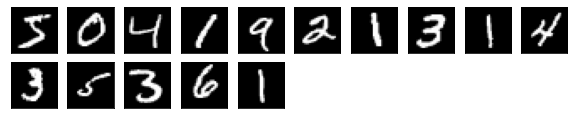

In [11]:
plt.figure(figsize= (10,10))
for i in range(15):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.axis('off')
    plt.imshow(x_train[i], cmap= 'gray')
plt.show()

In [12]:
batch_size= 32
dataset= tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset= dataset.batch(batch_size, drop_remainder = True).prefetch(1)

In [13]:

num_features= 100
generator= keras.models.Sequential([
    keras.layers.Dense(7*7*256, input_shape= [num_features]),
    keras.layers.Reshape([7,7,256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, (5,5),(2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5),(2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1,(5,5),(1,1),padding='same', activation='tanh')
])

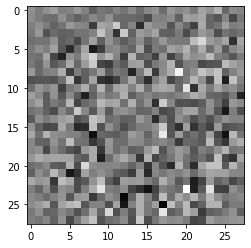

In [14]:
noise =tf.random.normal(shape=[1, num_features])
generated_image= generator(noise, training = False)
plt.imshow(generated_image[0,:,:,0], cmap='gray')
#plot_utils.show(generated_image, 1)

In [15]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        2

In [16]:
discriminator= keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape= [28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2DTranspose(128, (5,5),(2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2DTranspose(128, (5,5),(1,1), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 128)      

In [18]:
decision= discriminator(generated_image)
print(decision)

tf.Tensor([[0.4996999]], shape=(1, 1), dtype=float32)


In [19]:
discriminator.compile(loss= 'binary_crossentropy', optimizer= 'rmsprop')
discriminator.trainable= False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss= 'binary_crossentropy', optimizer= 'rmsprop')

In [20]:
seed= tf.random.normal(shape=[batch_size, 100])

In [21]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for i in tqdm( range(epochs)):
        print("Epoches {}/{}".format(i+1,epochs))
        for X_batch in dataset:
            noise= tf.random.normal(shape= [batch_size, num_features])
            generated_images= generator(noise)
            X_fake_and_real= tf.concat([generated_images, X_batch], axis=0)
            y1= tf.constant([[0.]]* batch_size +[[1.]]* batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2= tf.constant([[1.]]*batch_size)
            discriminator.trainable= False
            gan.train_on_batch(noise,y2)
        display.clear_output(wait= True)
        generate_and_save_images(generator, i+1, seed)
    display.clear_output(wait= True)
    generate_and_save_images(generator, epochs, seed)

In [22]:

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [23]:
x_train_dcgan= x_train.reshape(-1, 28, 28,1)*2. -1.

In [24]:
batch_size= 32
dataset= tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset= dataset.batch(batch_size, drop_remainder= True).prefetch(1)

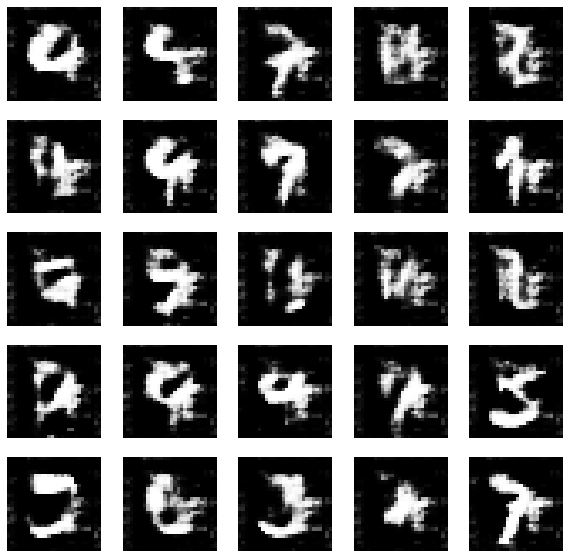

CPU times: user 12min 15s, sys: 55.7 s, total: 13min 11s
Wall time: 22min 16s


In [36]:
%%time
train_dcgan(gan,dataset, batch_size, num_features, epochs= 20)

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

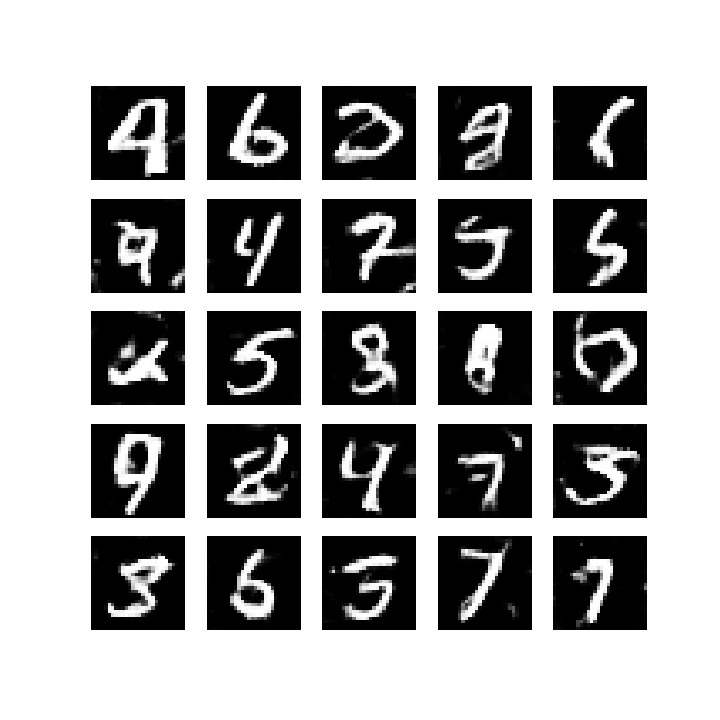

In [38]:
from pathlib import Path
#anim_file = 'dcgan.gif'
gifPath = Path("dcgan.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

In [ ]:
# Generate GIF for python 
import imageio
from pathlib import Path

picsPath = Path("dcgan.gif")
images = []
for f in picsPath.glob("*.png"):
    images.append(imageio.imread(f))
imageio.mimsave(picsPath / 'movie.gif', images)

In [ ]:
## gif that works at only jupyter 
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)